## Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

## Loading the dataset

In [3]:
X_train = torch.load("../train/X_train.pt")
y_train = torch.load("../train/y_train.pt")

X_valid = torch.load("../valid/X_valid.pt")
y_valid = torch.load("../valid/y_valid.pt")

X_test = torch.load("../test/X_test.pt")
y_test = torch.load("../test/y_test.pt")

In [4]:
classes_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'NULL', 'a', 'b', 'bye', 'c', 'd', 'e',
 'good', 'good morning', 'hello', 'little bit', 'no', 'pardon', 'please',
 'project', 'whats up', 'yes']

## Shape of the dataset
#### Checking the shapes

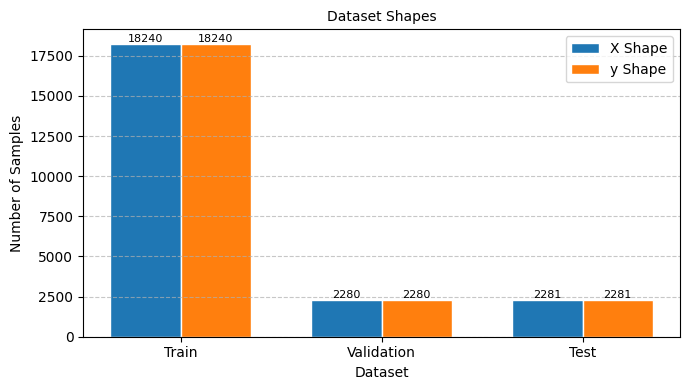

In [40]:
datasets = ['Train', 'Validation', 'Test']
X_shapes = [X_train.shape[0], X_valid.shape[0], X_test.shape[0]]
y_shapes = [y_train.shape[0], y_valid.shape[0], y_test.shape[0]]

plt.figure(figsize=(7, 4))

bar_width = 0.35
r1 = range(len(datasets))
r2 = [x + bar_width for x in r1]

plt.bar(r1, X_shapes, width=bar_width, edgecolor='white', label='X Shape')
plt.bar(r2, y_shapes, width=bar_width, edgecolor='white', label='y Shape')

for i in range(len(datasets)):
    plt.text(r1[i], X_shapes[i] + 10, str(X_shapes[i]), ha='center', va='bottom', fontsize=8)
    plt.text(r2[i], y_shapes[i] + 10, str(y_shapes[i]), ha='center', va='bottom', fontsize=8)

plt.xlabel('Dataset', fontsize=10)
plt.ylabel('Number of Samples', fontsize=10)
plt.title('Dataset Shapes', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([r + bar_width / 2 for r in range(len(datasets))], datasets)
plt.legend()

plt.tight_layout()

## Creating DataLoaders

In [38]:
batch_size=32
train_shuffle=True
valid_shuffle=False
test_shuffle=False

In [39]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

In [40]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model definition

##### CNN Layers Shape Calculation

$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \times \text{padding}[0] - \text{dilation}[0] \times ( \text{kernel\_size}[0] - 1 ) - 1}{\text{stride}[0]} \right\rfloor + 1
$$

$$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2 \times \text{padding}[1] - \text{dilation}[1] \times ( \text{kernel\_size}[1] - 1 ) - 1}{\text{stride}[1]} \right\rfloor + 1
$$

where:

- $H_{\text{in}}$ is the input height.
- $W_{\text{in}}$ is the input width.
- $\text{padding}[0]$ is the padding added to the input height.
- $\text{padding}[1]$ is the padding added to the input width.
- $\text{dilation}[0]$ is the dilation factor for the convolutional kernel in the height dimension.
- $\text{dilation}[1]$ is the dilation factor for the convolutional kernel in the width dimension.
- $\text{kernel\_size}[0]$ is the height of the convolutional kernel.
- $\text{kernel\_size}[1]$ is the width of the convolutional kernel.
- $\text{stride}[0]$ is the stride of the convolution in the height dimension.
- $\text{stride}[1]$ is the stride of the convolution in the width dimension.

In [41]:
def calculate_h_out_w_out(h_in, w_in, kernel_size, out_channels, stride=(1, 1), padding=(0, 0), dilation=(1, 1)):
    h_out = (h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) // stride[0] + 1
    w_out = (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) // stride[1] + 1

    # Assert if result height and width are integers
    assert isinstance(h_out, int), "Output height is not an integer"
    assert isinstance(w_out, int), "Output width is not an integer"
    
    return (h_out, w_out, out_channels)

In [38]:
class CNN(nn.Module):
    def __init__(self, in_height, in_width, in_channels, num_classes):
        super(CNN, self).__init__()

        # (32, 32, 3)
        self.in_features = (in_height, in_width, in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(5, 5), padding=(2, 2))
        self.in_features = calculate_h_out_w_out(in_height, in_width, (5, 5), 16, padding=(2, 2))
        # (32, 32, 16)
        
        self.relu1 = nn.ReLU()

        # (32, 32, 16)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))
        # (16, 16, 16)

        # (16, 16, 16) --> in_features=16*16*16
        self.fc1 = nn.Linear(in_features=self.in_features[0] * self.in_features[1] * self.in_features[2], out_features=2048)
        self.relu2 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=2048, out_features=num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.relu2(x)

        x = self.fc2(x)
        x = self.logSoftmax(x)
        return x

## Training

##### Function for choosing the device 

In [43]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Function for counting number of paramaters for model

In [44]:
def count_parameters(model):
  total_params = sum(p.numel() for p in model.parameters())

  # Iterate through the layers and print their details
  for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

  return total_params

##### Function for training

In [45]:
def train(model, criterion, optimizer, n_epochs, train_loader, valid_loader, multiclass=False):
    # Initialize lists for traininf and validation loss and accuracy for each epoch
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    # Get the appropriate device
    device = get_device()

    # Iterate over each epoch
    for epoch in range(n_epochs):
        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> TRAINING <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        model.train()                                # Set the model to training mode
        
        epoch_train_batches_loss = 0.0               # Loss for the current epoch
        epoch_train_correct_predictions = 0          # Number of correct predictions
        epoch_train_total_predictions = 0            # Total number of instances processed

        # Iterate over batches in the training data loader
        for inputs, labels in train_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Gradients from the previous batch are zeroed out to prevent accumulation
            optimizer.zero_grad()
            
            # Compute the model output
            outputs = model(inputs)
            
            # Compute the loss based on the criterion passed 
            loss = criterion(outputs.squeeze(), labels)
            
            # Compute the gradients
            loss.backward()
            
            # Update the model parameters using the optimizer
            optimizer.step()

            # Accumulate the loss for the current batch
            epoch_train_batches_loss += loss.item()

            # Predict
            if multiclass:
                predicted = torch.argmax(outputs, dim=1)
            else:
                predicted = (outputs > 0.5).float()
            
            # Update the number of correct predictions
            epoch_train_correct_predictions += (predicted.squeeze() == labels).sum().item()
            
            # Update the total number of instances processed
            epoch_train_total_predictions += labels.size(0)

        # Calculate the average loss for the training epoch
        epoch_train_loss = epoch_train_batches_loss / len(train_loader)
        
        # Calculate the accuracy for the training epoch
        epoch_train_accuracy = epoch_train_correct_predictions / epoch_train_total_predictions
        
        # Store the loss and accuracy for training
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> VALIDATION <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        model.eval()                               # Set the model to evaluation mode
        
        epoch_valid_loss = 0.0                       # Loss for the current validation epoch
        epoch_valid_correct_predictions = 0          # Number of correct predictions
        epoch_valid_total_predictions = 0            # Total number of instances processed
        
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in valid_loader:
                # Move inputs and labels to the device
                inputs, labels = inputs.to(device), labels.to(device)

                # Compute the model output
                outputs = model(inputs)
                
                # Compute the loss based on the criterion passed 
                loss = criterion(outputs.squeeze(), labels)
                
                # Accumulate the loss for the current batch
                epoch_valid_loss += loss.item()

                # Predict
                if multiclass:
                    predicted = torch.argmax(outputs, dim=1)
                else:
                    predicted = (outputs > 0.5).float()
                
                # Update the number of correct predictions
                epoch_valid_correct_predictions += (predicted.squeeze() == labels).sum().item()
                
                # Update the total number of instances processed
                epoch_valid_total_predictions += labels.size(0)
        
        # Calculate the average loss and accuracy for the validation epoch
        epoch_valid_loss /= len(valid_loader)
        epoch_valid_accuracy = epoch_valid_correct_predictions / epoch_valid_total_predictions

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_accuracy)
        
        print(f"Epoch [{epoch + 1}/{n_epochs}], Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {epoch_train_accuracy:.4f}, "
              f"Val Loss: {epoch_valid_loss:.4f}, Val Accuracy: {epoch_valid_accuracy:.4f}")

    # Return the losses and accuracies over all epochs
    return train_losses, train_accuracies, valid_losses, valid_accuracies

##### Instantiate model

In [46]:
image_height = X_train.shape[2]
image_width = X_train.shape[2]
n_channels = X_train.shape[1]
n_classes = len(np.unique(y_train))

In [47]:
model = CNN(in_height=image_height, in_width=image_width, in_channels=n_channels, num_classes=n_classes)
model

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=2048, out_features=27, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

##### Counting number of parameters

In [48]:
count_parameters(model)

Layer: conv1, Parameters: 1216
Layer: relu1, Parameters: 0
Layer: maxpool1, Parameters: 0
Layer: fc1, Parameters: 8390656
Layer: relu2, Parameters: 0
Layer: fc2, Parameters: 55323
Layer: logSoftmax, Parameters: 0


8447195

##### Train

In [49]:
n_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [50]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, criterion, optimizer, n_epochs, train_loader, valid_loader, True)

Epoch [1/10], Train Loss: 2.4010, Train Accuracy: 0.2896, Val Loss: 1.6637, Val Accuracy: 0.4820
Epoch [2/10], Train Loss: 1.3321, Train Accuracy: 0.5919, Val Loss: 1.2583, Val Accuracy: 0.6070
Epoch [3/10], Train Loss: 0.8366, Train Accuracy: 0.7445, Val Loss: 1.0512, Val Accuracy: 0.6741
Epoch [4/10], Train Loss: 0.4750, Train Accuracy: 0.8572, Val Loss: 1.0265, Val Accuracy: 0.6969
Epoch [5/10], Train Loss: 0.2475, Train Accuracy: 0.9302, Val Loss: 1.0560, Val Accuracy: 0.7175
Epoch [6/10], Train Loss: 0.1252, Train Accuracy: 0.9691, Val Loss: 1.0836, Val Accuracy: 0.7316
Epoch [7/10], Train Loss: 0.0789, Train Accuracy: 0.9808, Val Loss: 1.1505, Val Accuracy: 0.7311
Epoch [8/10], Train Loss: 0.0744, Train Accuracy: 0.9804, Val Loss: 1.3796, Val Accuracy: 0.7035
Epoch [9/10], Train Loss: 0.0990, Train Accuracy: 0.9722, Val Loss: 1.4216, Val Accuracy: 0.7031
Epoch [10/10], Train Loss: 0.0521, Train Accuracy: 0.9868, Val Loss: 1.5828, Val Accuracy: 0.6851


## Ploting results of the training

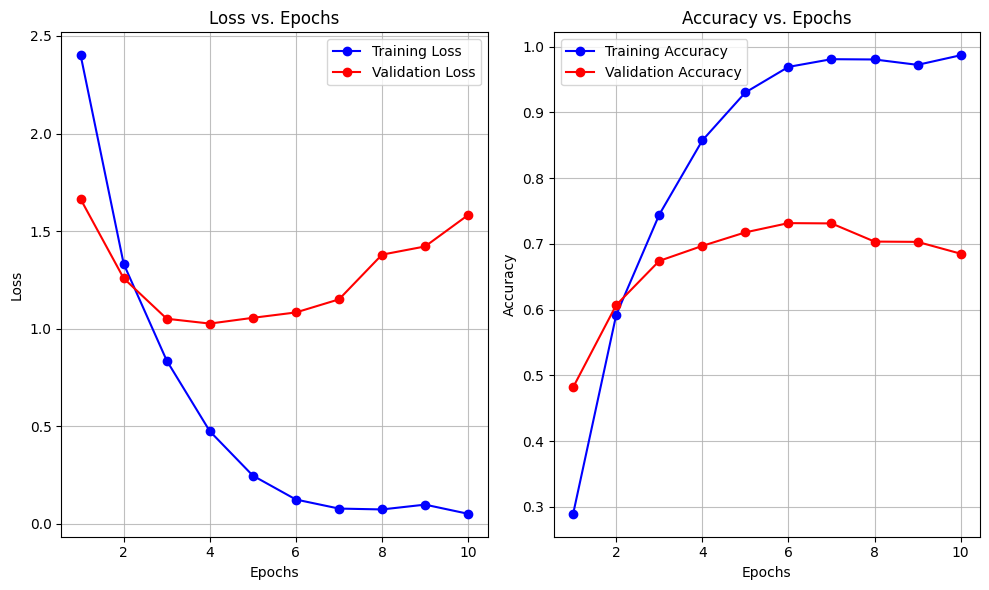

In [51]:
def plot_training_curves(train_losses, train_accuracies, valid_losses, valid_accuracies):
    FIGSIZE=(10, 6)
    DPI=100
    ALPHA=0.8
    
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=FIGSIZE, dpi=DPI)
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('on', alpha=ALPHA)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid('on', alpha=ALPHA)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, train_accuracies, valid_losses, valid_accuracies)

## Evaluation

##### Function for evaluating

In [52]:
def evaluate(model, criterion, loader, multiclass=False):
    # Set the model to evaluation mode
    model.eval()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    predicted_labels, true_labels = [], []
    
    # Get the device
    device = get_device()

    # Disable gradient computation during evaluation
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get model predictions
            outputs = model(inputs)
            
            # Compute loss
            total_loss += criterion(outputs.squeeze(), labels).item()

            # Predict class labels
            if multiclass:
                predicted = torch.argmax(outputs, dim=1)
            else:
                predicted = (outputs > 0.5).float()
                
            # Append predictions and true labels for metric computation
            predicted_labels.extend(predicted.squeeze().tolist())
            true_labels.extend(labels.tolist())

            # Update total samples and correct predictions count
            total_samples += labels.size(0)
            total_correct += (predicted.squeeze() == labels).sum().item()

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    
    # Print evaluation results
    print(f'Model evaluation on: {loader}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d',  xticklabels=classes_names,  yticklabels=classes_names)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

    # Average loss over all batches
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x000001975D468340>
Accuracy: 0.6851
Precision: 0.7076
Recall: 0.6851
F1 Score: 0.6838


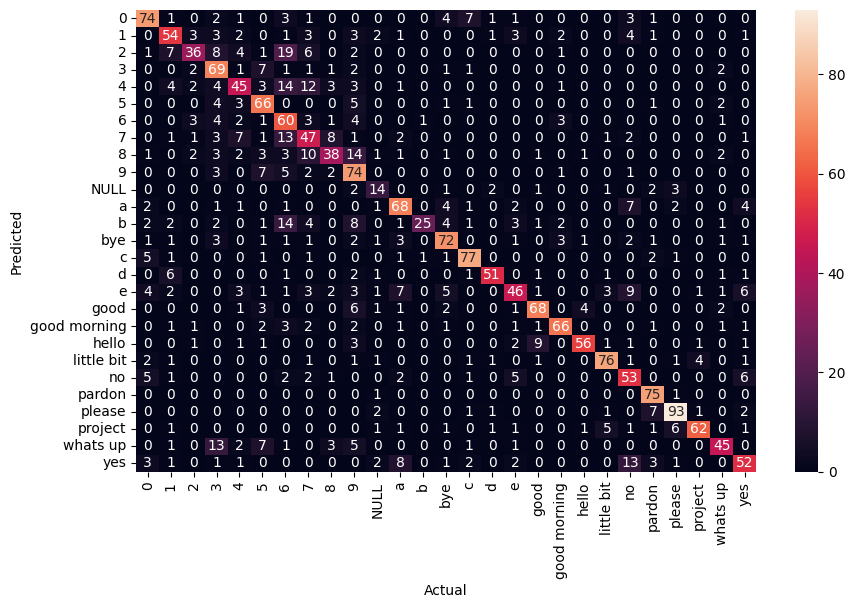

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x000001975DB39CF0>
Accuracy: 0.6883
Precision: 0.7173
Recall: 0.6883
F1 Score: 0.6917


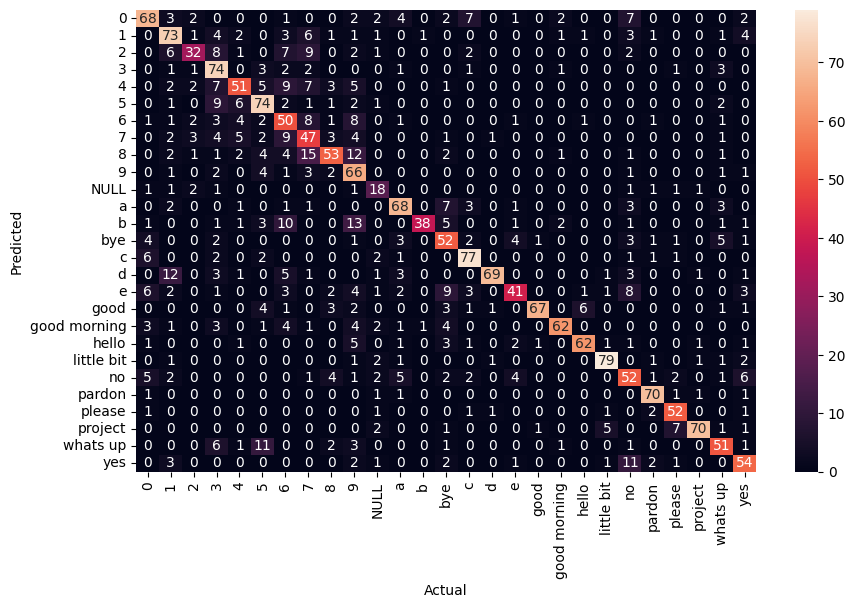

In [56]:
# Evaluate on validation and test sets
print("="*150)
valid_loss, valid_accuracy = evaluate(model, criterion, valid_loader, multiclass=True)
print("="*150)
test_loss, test_accuracy = evaluate(model, criterion, test_loader, multiclass=True)

In [57]:
# Print the results
print("\nEvaluation Results:")
print("="*50)
print(f"{'Metric':<20} {'Validation':<15} {'Test':<15}")
print("-"*50)
print(f"{'Loss':<20} {valid_loss:.4f}       {test_loss:.4f}")
print(f"{'Accuracy':<20} {valid_accuracy:.4f}       {test_accuracy:.4f}")
print("="*50)


Evaluation Results:
Metric               Validation      Test           
--------------------------------------------------
Loss                 1.5828       1.5229
Accuracy             0.6851       0.6883


## Saving the model

In [58]:
torch.save(model.state_dict(), 'models/model1.pth')